　「RとStanで始めるベイズ統計モデリングによるデータ分析入門」「実践編第5部第8章 動的一般化線形モデル：二項分布を仮定した例」を対象に，公開されているR，Stanのコードをpython，pystanのコードへと書き直した一例です。Stanの代わりにpystanを利用しています。

　この章では，観測方程式に二項分布を用いた動的一般化線形モデル（DGLM)が解説されています。

　本ページでは公開されていない書籍の内容については一切触れません。理論や詳しい説明は書籍を参照してください。

　なお，こちらで紹介しているコードには誤りが含まれる可能性があります。内容やコードについてお気づきの点等ございましたら，ご指摘いただけると幸いです

# 分析の準備
## パッケージの読み込み

In [1]:
import arviz
import pystan
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['font.family'] = 'Meiryo'
import seaborn as sns

# 自作のplotSSM関数を読み込み
from plotSSM import plotSSM

## データの読み込み
　こちらで読み込んでいる「boat.csv」は，R上で読み込んだ「boat」データセットを「write.csv(boat, 'boat.csv')」によってcsvファイルに出力したものを利用しています。

In [34]:
boat = pd.read_csv('boat.csv',
                   header=0,                   # 最初の行をheader指定
                   index_col=0,                # 最小の列をindex指定
                   names=['victory or defeat'])# 列名変更
display(boat)

,victory or defeat
1,0.0
2,NaN
3,NaN
4,NaN
5,NaN
...,...
179,1.0
180,0.0
181,0.0
182,1.0


# 二項分布を仮定したDGLMの推定
## 参考

In [35]:
print(np.logical_not(boat['victory or defeat'].isnull()))  # データがあればTrue

1       True
2      False
3      False
4      False
5      False
       ...  
179     True
180     True
181     True
182     True
183     True
Name: victory or defeat, Length: 183, dtype: bool


In [77]:
ind = boat[np.logical_not(boat['victory or defeat'].isnull())].index
print(ind) # データがある時点一覧

Int64Index([  1,   8,  11,  12,  13,  14,  17,  18,  21,  24,
            ...
            174, 175, 176, 177, 178, 179, 180, 181, 182, 183],
           dtype='int64', length=155)


## NAを除く

In [42]:
boat_omit_NA = boat.dropna(axis=0)

## データの準備

In [75]:
data_list = dict(T=len(boat),
                 len_obs=len(boat_omit_NA),
                 y=boat_omit_NA['victory or defeat'].astype(int), # int型へ変換
                 obs_no=ind
                 )

## モデルの推定

In [76]:
# stanコードの記述（5-8-1-dglm-binom.stan）
stan_code = '''
data {
  int T;               // データ取得期間の長さ
  int len_obs;         // 観測値が得られた個数
  int y[len_obs];      // 観測値
  int obs_no[len_obs]; // 観測値が得られた時点
}

parameters {
  vector[T] mu;       // 状態の推定値
  real<lower=0> s_w;  // 過程誤差の標準偏差
}

model {
  // 弱情報事前分布
  s_w ~ student_t(3, 0, 10);
  
  // 状態方程式に従い、状態が遷移する
  for(i in 2:T) {
    mu[i] ~ normal(mu[i-1], s_w);
  }
  
  // 観測方程式に従い、観測値が得られる
  // ただし、「観測値が得られた時点」でのみ実行する
  for(i in 1:len_obs) {
    y[i] ~ bernoulli_logit(mu[obs_no[i]]);
  }
}

generated quantities{
  vector[T] probs;       // 推定された勝率
  
  probs = inv_logit(mu);
}

'''

# モデルのコンパイル
stan_model = pystan.StanModel(model_code=stan_code)

# サンプリング
dglm_binom = stan_model.sampling(data=data_list,
                                 seed=1,
                                 iter=30000,
                                 warmup=10000,
                                 thin=20,
                                 n_jobs=1)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_7ddd0d92330219129ee77bde56cd3307 NOW.


## 推定されたパラメタ

In [78]:
print(dglm_binom.stansummary(pars=["s_w", "lp__"], probs=[0.025, 0.5, 0.975]))

Inference for Stan model: anon_model_7ddd0d92330219129ee77bde56cd3307.
4 chains, each with iter=30000; warmup=10000; thin=20; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

       mean se_mean     sd   2.5%    50%  97.5%  n_eff   Rhat
s_w    0.74    0.02   0.39   0.21   0.68   1.71    582   1.01
lp__ -96.76    3.76  86.34 -252.7 -104.4  88.46    527   1.01

Samples were drawn using NUTS at Sun Sep 13 15:30:56 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


## 参考：収束の確認

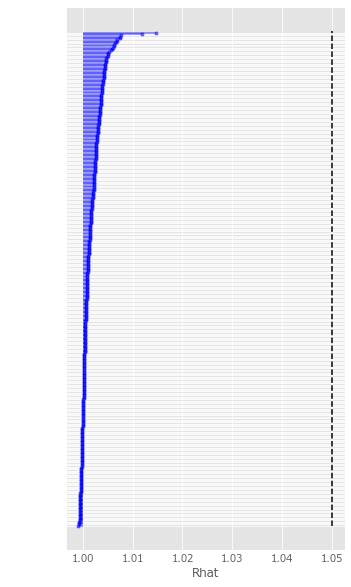

In [79]:
# 収束確認用のRhatのプロット関数
def mcmc_rhat(dataframe, column='Rhat', figsize=(5, 10)):
    plt.figure(figsize=figsize)
    plt.hlines(y=dataframe[column].sort_values().index,
               xmin=1,
               xmax=dataframe[column].sort_values(),
               color='b',
               alpha=0.5)
    plt.vlines(x=1.05, ymin=0, ymax=len(dataframe[column]), linestyles='--')
    plt.plot(dataframe[column].sort_values().values,
             dataframe[column].sort_values().index,
             marker='.',
             linestyle='None',
             color='b',
             alpha=0.5)
    plt.yticks(color='None')
    plt.tick_params(length=0)
    plt.xlabel(column)
    plt.show()


# 各推定結果のデータフレームを作成
summary = pd.DataFrame(dglm_binom.summary()['summary'],
                       columns=dglm_binom.summary()['summary_colnames'],
                       index=dglm_binom.summary()['summary_rownames'])

# プロット
mcmc_rhat(summary)

In [80]:
print('hmc_diagnostics:\n',
      pystan.diagnostics.check_hmc_diagnostics(dglm_binom))

hmc_diagnostics of local_level:
 {'n_eff': True, 'Rhat': True, 'divergence': True, 'treedepth': True, 'energy': True}


## 参考:トレースプロット
 'lp__'（log posterior）のトレースプロットは図示できないため除いています。

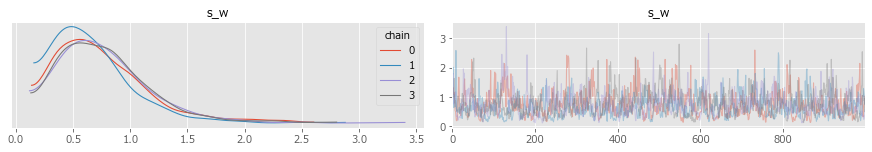

In [84]:
arviz.plot_trace(dglm_binom, var_names=["s_w"], legend=True);

## 参考：推定結果一覧

In [83]:
print(dglm_binom.stansummary(probs=[0.025, 0.5, 0.975]))

Inference for Stan model: anon_model_7ddd0d92330219129ee77bde56cd3307.
4 chains, each with iter=30000; warmup=10000; thin=20; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

             mean se_mean     sd   2.5%    50%  97.5%  n_eff   Rhat
mu[1]        -0.4    0.04   1.95  -4.85   -0.2   2.91   2139    1.0
mu[2]       -0.17    0.03   1.91  -4.45  -0.03   3.17   3020    1.0
mu[3]        0.08    0.03   1.83  -3.78   0.21   3.41   3737    1.0
mu[4]        0.32    0.03   1.79  -3.49    0.4   3.71   4119    1.0
mu[5]        0.59    0.03    1.7  -2.79   0.61   4.02   4164    1.0
mu[6]        0.83    0.03   1.63  -2.35    0.8   4.25   4043    1.0
mu[7]        1.05    0.02   1.54  -1.78   0.97   4.39   3806    1.0
mu[8]        1.29    0.03   1.47  -1.17   1.13   4.67   2601    1.0
mu[9]        1.35    0.03   1.46  -1.14   1.23   4.78   2406    1.0
mu[10]       1.42    0.03   1.42  -0.95   1.28   4.65   2004    1.0
mu[11]        1.5    0.03   1.32  -0.67   1.34   4.46   1746

# 推定された状態の図示
## 時間ラベルの作成

In [98]:
years = pd.date_range('1829-01-01', periods=len(boat), freq='12MS')
print(years[:3])

DatetimeIndex(['1829-01-01', '1830-01-01', '1831-01-01'], dtype='datetime64[ns]', freq='12MS')


## MCMCサンプルの取得

In [99]:
mcmc_sample = dglm_binom.extract()

## ケンブリッジ大学の勝率の推移のグラフ

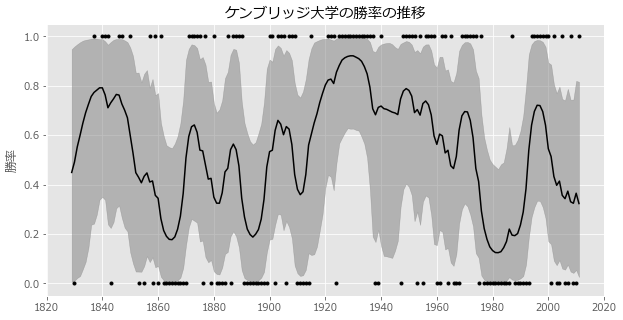

In [103]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

p = plotSSM(mcmc_sample=mcmc_sample,
                time_vec=years,
                obs_vec=boat_omit_NA['victory or defeat'].astype(int),
                state_name='probs',
                graph_title='ケンブリッジ大学の勝率の推移',
                y_label='勝率',
                axes=ax)

plt.show()

## ケンブリッジ大学の平均勝率

In [104]:
boat_omit_NA['victory or defeat'].mean()

0.5161290322580645